# The enablement of household electrification in the US

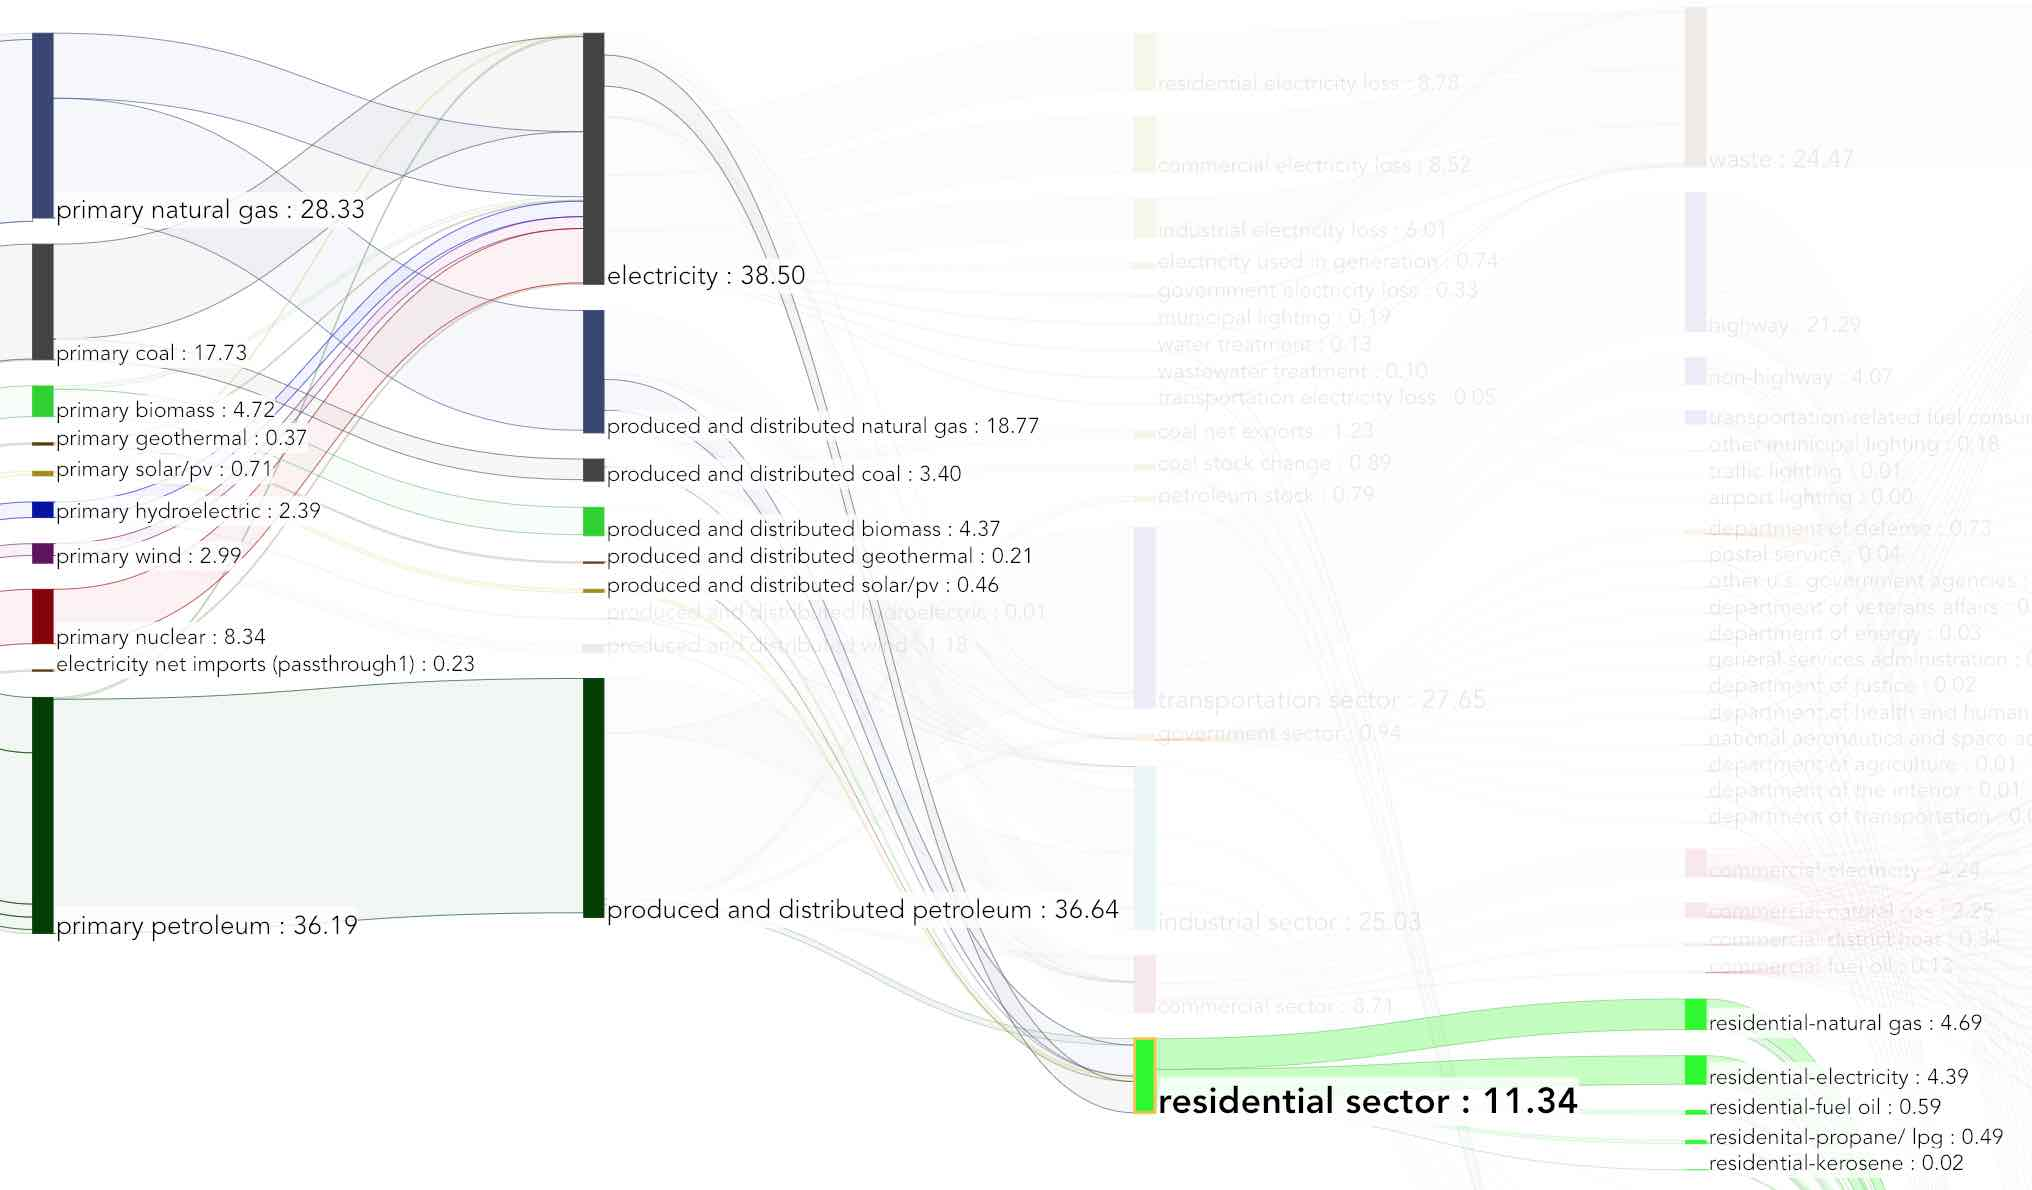
US energy Sankey diagram from http://www.departmentof.energy/.

# Overview

Two of the main take-aways from the multitude of climate mitigation and adaptation reports in the past several years [1,2] have been:
1. We must get off of fossil fuels as quickly as possible to reach the IPCC target of 1.5°C global warming.
2. We can significantly reduce our carbon footprint with the **technology we have today** and **without altering our quality of life** through the rapid switch to renewable energy sources and by electrifying nearly every aspect of our lives, including our transportation and heating needs.  

One estimate projects that the primary energy usage needs of the US will be reduced by over half if the second point above is achieved [3]. This, in turn, makes the the first point much more attainable. In this notebook, we develop a set of KPIs focusing on the US market that center around the ability for the residents of a city to make this transition. Specifically, we focus on the following questions:
* What impact (in terms of GHG emissions reductions) can a city have in electrifying its residential electricity and heating sector given its current electricity source portfolio and heating needs? 
* To what extent is a city enabling its residents to make this transition?

To answer these questions, we attempt in this notebook to give an estimate of the following quantities:

* **Residential renewable electricity affordability**: The proportion of households in a city that can reasonably afford to install solar panels.
* **Residential heating electrification affordability**: The proportion of households in a city that can reasonably afford to switch to electric heat pumps for space and water heating.
* **Residential renewable electricity impact**: The extent to which a city's indirect GHG emissions from electiricy use can be abated through solar PV installations. 
* **Residential heating electrification impact**: The extent to which a city's direct GHG emissions from residential heating can be abated through electrification. 

The latter two indicators depend on estimates for the former two indicators. Based on these indicators, we consider two KPIs that aim to measure the market penetration of solar panels and heat pumps relative to the affordability of these technologies.

A corresponding set of metrics focusing on electric vehicle enablement was also considered. This however requires a more careful modeling of household car finances in the US as well as more comprehensive accounting of existing federal/state/municipal/utility-level incentives that is beyond the scope of this notebook.  We defer to the highly in-depth city-level EV adoption study by Bui et. al [4] for more details and inspiration.

Finally, we must note that there are many assumptions and approximations that will feed into the estimates of the quantities (and therefore the KPIs) described above. We believe that, though the estimates may be a good starting point for framing the discussion around the state of household electrification in the US, there is much that will need to be refined for these to more accurately and comprehensively represent a city's electrification impact and progress. We discuss some of these uncertainties at the end. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import re
import matplotlib.pyplot as plt
from os.path import join
from urllib.request import urlopen
import json

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import spacy 
nlp = spacy.load("en_core_web_sm") 

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option("max_colwidth", None)

In [ ]:
root_dir = "../input/cdp-unlocking-climate-solutions"
supp_root_dir = "../input/supplementary-data-for-cdp-analytics-competition"
#root_dir = "."

# import cities response df
cities_df = pd.read_csv(os.path.join(root_dir, "Cities/Cities Responses/2020_Full_Cities_Dataset.csv"))
cities_meta_df = pd.read_csv(os.path.join(root_dir, "Cities/Cities Disclosing/2020_Cities_Disclosing_to_CDP.csv"))

cities_df = pd.merge(cities_df,
                     cities_meta_df[['Account Number', 'City']],
                     on='Account Number',
                     how='left'
                    )

cities_df['City'] = cities_df['City'].fillna(cities_df['Organization'])
us_cities = cities_df[cities_df['Country']=='United States of America']['City'].unique()
us_cities_household_size = pd.read_csv(join(supp_root_dir, "persons_per_household.tsv"), header=None, names=['city', 'persons_per_household'], sep='\t')

def find_matching_city(city):
    for city_name in us_cities:
        if city in city_name:
            return city_name
    return None

us_cities_household_size['matching_city'] = us_cities_household_size['city'].apply(find_matching_city)
df_us_cities_household = us_cities_household_size[~pd.isnull(us_cities_household_size['matching_city'])][['matching_city', 'persons_per_household']].rename(columns={'matching_city':'city'})

cols = ['Account Number','Organization', 'Country', 'City','CDP Region', 'Response Answer']
populations = cities_df[(cities_df['Question Number']=="0.5")&(cities_df['Column Name']=="Current population")][cols].rename(columns={'Response Answer': 'population'})


# Electricity Source Mix

We start by considering the electricity source mix of each city.

In [ ]:
q_num = '8.1'
cols = ['Geothermal', 'Hydro', 'Coal', 'Biomass', 'Oil', 'Solar', 'Wind', 'Gas', 'Other sources', 'Nuclear']

def pivot_data(df):
    return df[['Column Name', 'Response Answer']].set_index('Column Name').transpose()

q_num_cond = (cities_df['Question Number']==q_num)&(cities_df['Column Name'].isin(cols))
df_elec_mix_summary = cities_df[q_num_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)

df_elec_mix_summary = df_elec_mix_summary.astype(float)
df_elec_mix_summary.fillna(0.0, inplace=True)
df_elec_mix_summary['total'] = df_elec_mix_summary.sum(axis=1)
df_elec_mix_summary['Unknown'] = df_elec_mix_summary['total'].apply(lambda x: 100-np.rint(x))
df_elec_mix_final = pd.merge(df_elec_mix_summary.reset_index(),
                             cities_df[['Account Number', 'City']].drop_duplicates(),
                             on='Account Number',
                             how='left')

us_elec_mix = df_elec_mix_final[df_elec_mix_final['City'].isin(us_cities)].copy()
#print("Number of cities:", len(us_elec_mix))
cols = ['Coal', 'Gas', 'Oil', 'Biomass', 'Nuclear', 'Solar', 'Geothermal', 'Wind', 'Hydro', 'Other sources', 'Unknown']
tmp = us_elec_mix.set_index("City")[cols].sort_values(by=['Coal', 'Gas', 'Oil', 'Unknown'], ascending=[True, True, True, False])
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)  # TODO: tweak color wheel to make it more intuitive
tmp.plot.barh(stacked=True, figsize=(6, 15 * (len(tmp)/40)), title='US cities')
plt.xlabel("electricity source")
plt.legend(loc=(1.04,0))
plt.show()

We can view the percentage of electricity from renewable sources on a map of the US.

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

def location_to_tuple(text):
    if isinstance(text, str):
        point = text.split(' ')[1:]
        point[0] = float(point[0].replace("(", ""))
        point[1] = float(point[1].replace(")", ""))
        return point
    return None

#location_to_tuple(cities_meta_df.iloc[0]['City Location'])
# latitude is 36, longitude is -86    

#point = Point(-86.7816, 36.1627)
#polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
#print(polygon.contains(point))

depth = lambda L: isinstance(L, list) and max(map(depth, L))+1

def count(l):
    return sum(1+count(i) for i in l if isinstance(i,list))

def find_county(longitude, latitude):
    the_point = Point(longitude, latitude)
    for county in counties['features']:
        if depth(county['geometry']['coordinates']) == 3: 
            poly = county['geometry']['coordinates'][0]
            county_polygon = Polygon(poly)
            if county_polygon.contains(the_point):
                return county['id']
        elif depth(county['geometry']['coordinates']) == 4:
            for region in county['geometry']['coordinates']:
                poly = region[0]
                county_polygon = Polygon(poly)
                if county_polygon.contains(the_point):
                    return county['id']                
    return None

#find_county(-86.7816, 36.1627)
#find_county(-118.481, 34.0219)

def find_county_df(x):
    return find_county(*x) if x else None

# from Google
supplement_city_locations = pd.DataFrame([("San Luis Obispo", "POINT (-120.6596 35.2828)"),
("City of Aurora, IL", "POINT (-88.3201 41.7606)"),
("Orange County, NC", "POINT (-79.1097 36.0263)"),
("Summit County, UT", "POINT (-110.9984 40.8298)"),
("City of Omaha", "POINT (-95.9345 41.2565)"),
("City of St. Petersburg", "POINT (-82.6403 27.7676)"),
("Town of Princeton, NJ", "POINT (-74.6672 40.3573)"),
("City of South Bend, IN", "POINT (-86.2520 41.6764)"),
("Town of Breckenridge, CO", "POINT (-106.0384 39.4817)"),
("City of Eau Claire, WI", "POINT (-91.4985 44.8113)"),
("City of Birmingham", "POINT (-86.8104 33.5186)"),
("City of Berkeley", "POINT (-122.2730 37.8715)"),
("City of Highland Park, IL", "POINT (-87.8003 42.1817)"),
("City of Grand Rapids", "POINT (-85.6681 42.9634)"),
("City of Beverly, MA", "POINT (-70.8800 42.5584)"),
("City of Key West, FL", "POINT (-81.7800 24.5551)"),
("Village of South Barrington, IL", "POINT (-88.1535 42.0881)"),
("City of Henderson", "POINT (-114.9817 36.0395)"),
("City of Albuquerque", "POINT (-106.6504 35.0844)"),
("City of Alameda", "POINT (-122.2822 37.7799)"),
("Town of York, ME", "POINT (-70.6483 43.1617)"), 
("Village of Park Forest, IL", "POINT (-87.6745 41.4914)"),
("City of Holland, MI", "POINT (-86.1089 42.7875)"),
("Arlington, VA", "POINT (-77.0910 38.8816)"),
#                                           ("City of Milwaukie, OR", ),
#                                           ("Dane County", ),
#                                           ("City of Racine, WI", ),
#                                           ("City of Spokane", ),
#                                           ("City of Greenbelt, MD", )
#                                           ("City of Wilmington, NC", ),
#                                           ("Town of Guilford, VT", ),
#                                           ("City of Ashland, OR", ),
("Cuyahoga County", "POINT (-81.6758 41.4339)"),
                                         ], columns=['Organization', 'City Location'])
#supplement_city_locations

In [ ]:
renewable_cols = ['Biomass', 'Nuclear', 'Solar', 'Geothermal', 'Wind', 'Hydro', 'Other sources']
us_elec_mix['total_renewable'] = us_elec_mix[renewable_cols].sum(axis=1)
cities_meta_df['City Location tuple'] = cities_meta_df['City Location'].apply(location_to_tuple)
cities_meta_df['county_id'] = cities_meta_df['City Location tuple'].progress_apply(find_county_df)

known_mix = (us_elec_mix['total']==100)
us_elec_mix_with_county_id = pd.merge(us_elec_mix[known_mix], cities_meta_df, on='Account Number')[['Account Number', 'Organization','county_id', 'total_renewable']]
#pd.isnull(us_elec_mix_with_county_id['county_id']).sum() / len(us_elec_mix_with_county_id)

df_supplement_city_loc = pd.merge(cities_meta_df[['Account Number', 'Organization']].drop_duplicates(),#us_elec_mix_with_county_id,
                                  supplement_city_locations,
                                  on='Organization')

for i,row in df_supplement_city_loc.iterrows():
    cities_meta_df.loc[cities_meta_df['Account Number']==row['Account Number'], 'City Location'] = row['City Location']
    
cities_meta_df['City Location tuple'] = cities_meta_df['City Location'].apply(location_to_tuple)
cities_meta_df['county_id'] = cities_meta_df['City Location tuple'].progress_apply(find_county_df)    

In [ ]:
# get state name (needed for later)
# https://www.kaggle.com/c/cdp-unlocking-climate-solutions/discussion/199694
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")
def city_state_country(coord):
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    #city = address.get('city', '')
    state = address.get('state', '')
    #country = address.get('country', '')
    return state

#print(city_state_country("44.4938, 11.3387")) #Account number=36274 and point=(11.3387 44.4938)

def get_state(city_location_tuple):
    if city_location_tuple:
        try:
            return city_state_country(str([el for el in reversed(city_location_tuple)]).replace("[","").replace("]",""))
        except:
            print("Unknown address")
    return None

cities_meta_df['State'] = cities_meta_df['City Location tuple'].progress_apply(get_state)

cities_meta_df['City'] = cities_meta_df['City'].fillna(cities_meta_df['Organization'])

us_elec_mix_with_county_id = pd.merge(us_elec_mix[known_mix], cities_meta_df, on='Account Number')[['Account Number', 'Organization','county_id', 'total_renewable']]


In [ ]:
import plotly.express as px
fig = px.choropleth(us_elec_mix_with_county_id[~pd.isnull(us_elec_mix_with_county_id['county_id'])][['county_id', 'total_renewable', 'Organization']],
                    geojson=counties, locations='county_id', color='total_renewable',
                    #color_continuous_scale="Viridis",
                    color_continuous_scale=['red', 'yellow', 'green'],
                    range_color=(0, 100),
                    #scope="north america",
                    scope='usa',
                    hover_data=['Organization', 'total_renewable'],
                    labels={'total_renewable':'renewable elec. source %'},
                    #title='Percentage of electricity from renewable sources'
                          )
#fig.update_geos(resolution=50)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

We can see that much of the west coast and New England areas have a high renewable source electricity portfolio. The electricity source mix is a factor in the determination of the residential renewable enablement metrics. 

# GHG emissions

We next consider the GHG emissions reported by eacy city.

## Direct emissions

Direct emissions come from activities such as the burning of natural gas for space and water heating or petroleum for transport.  This is each city's breakdown of direct emissions by sector:

In [ ]:
q_num="4.6a"
# 4.6a The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new 
# Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your 
# city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use 
# the relevant notation keys to explain the reason why.

col = "Direct emissions (metric tonnes CO2e)"

def pivot_data(df):
    return df[['Row Name', 'Response Answer']].set_index('Row Name').transpose()

q_num_cond = (cities_df['Question Number']==q_num)&(cities_df['Column Name']==col)
row_cond = (cities_df['Row Name'].str.contains("Total"))
df_ghg_breakdown_summary = cities_df[q_num_cond&row_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)
#len(df_ghg_breakdown_summary)

df_ghg_breakdown_summary = df_ghg_breakdown_summary[df_ghg_breakdown_summary['Total Transport']!='Question not applicable'].copy()
df_ghg_breakdown_summary.fillna(0, inplace=True)
df_ghg_breakdown_summary = df_ghg_breakdown_summary.astype(float)

# number of cities with a ghg summary
#na_cities = cities_df[cities_df['CDP Region']=="North America"]
#len(na_cities['Organization'].unique()), df_ghg_breakdown_summary.index.isin(na_cities['Account Number'].unique()).sum()

cols = ['Total IPPU', 'Total Stationary Energy', 'Total Transport', 'Total Waste', 'Total AFOLU']
df_ghg_breakdown_summary['check_diff'] = df_ghg_breakdown_summary['Total Emissions (excluding generation of grid-supplied energy)'] - df_ghg_breakdown_summary[cols].sum(axis=1)

# number of cities with a consistent GHG breakdown
consistent_ghg_total = df_ghg_breakdown_summary['check_diff'].abs() <20

df_ghg_summary_final = pd.merge(df_ghg_breakdown_summary[consistent_ghg_total].reset_index(),
                                cities_df[['Account Number', 'City']].drop_duplicates(),
                                on='Account Number',
                                how='left')

total_col = 'Total Emissions (excluding generation of grid-supplied energy)'
ghg_summary_for_plot = df_ghg_summary_final[df_ghg_summary_final[total_col]>0].set_index('City').sort_values([total_col]).loc[:, cols]

us_direct_ghg_summary = ghg_summary_for_plot[ghg_summary_for_plot.index.isin(us_cities)]
#print("Total number of cities:", len(us_cities))
#print("Total number with summary:", len(us_direct_ghg_summary))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
us_direct_ghg_summary.plot.barh(stacked=True, figsize=(6, 15 * (len(us_direct_ghg_summary)/40)), title='US cities')
plt.xlabel("GHG emissions (excl. grid energy gen) (metric tonnes CO2e)")
plt.legend(loc=(1.04,0))
plt.show()

Per capita, we get the following picture:

In [ ]:
us_direct_ghg_summary_per_capita = pd.merge(us_direct_ghg_summary.reset_index(),
                                            populations[['City', 'population']],
                                            on='City',
                                            how='left')
    
us_direct_ghg_summary_per_capita.set_index('City', inplace=True)
us_direct_ghg_summary_per_capita = us_direct_ghg_summary_per_capita.astype(float)
us_direct_ghg_summary_per_capita = us_direct_ghg_summary_per_capita.div(us_direct_ghg_summary_per_capita['population'],axis='rows').drop(['population'], axis=1)
us_direct_ghg_summary_per_capita['total'] = us_direct_ghg_summary_per_capita.astype(float).sum(axis=1)
us_direct_ghg_summary_per_capita.sort_values(by='total')[us_direct_ghg_summary_per_capita.columns[:-1]].plot.barh(stacked=True,  
                                                                                                                  figsize=(6, 15 * (len(us_direct_ghg_summary_per_capita)/40)),                                                                             
                                                                                                                  title='US cities')

plt.xlabel("Direct GHG emissions per capita")
plt.legend(loc=(1.04,0))
plt.show()

For nearly all cities for which we have consistent and complete reporting, we can see that stationary energy and transport makes up nearly all of the GHG emissions.  As we are focused on the stationary sector in our metrics, we take a look at the subsector breakdown.  

In [ ]:
# what is the sector breakdown of the stationary energy

row_cond = (cities_df['Row Name'].str.contains("Stationary energy > "))
df_direct_stationary_breakdown = cities_df[q_num_cond&row_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)

df_direct_stationary_breakdown = df_direct_stationary_breakdown[df_direct_stationary_breakdown['Stationary energy > Residential buildings']!='Question not applicable'].astype(float).fillna(0)
df_direct_stationary_breakdown_final = pd.merge(df_direct_stationary_breakdown.reset_index(),
                                                cities_df[['Account Number', 'City']].drop_duplicates(),
                                                on='Account Number',
                                                how='left')
us_direct_stationary_breakdown = df_direct_stationary_breakdown_final[df_direct_stationary_breakdown_final['City'].isin(us_cities)]
us_direct_stationary_breakdown = pd.merge(us_direct_stationary_breakdown,
                                          us_direct_ghg_summary.reset_index(),
                                          on='City')
stat_columns = ['Stationary energy > Residential buildings',
                'Stationary energy > Commercial buildings & facilities',
                'Stationary energy > Industrial buildings & facilities',
                'Stationary energy > Agriculture',
                'Stationary energy > Institutional buildings & facilities',
                'Stationary energy > Fugitive emissions']

us_direct_stationary_breakdown = us_direct_stationary_breakdown.set_index('City')[stat_columns]
us_direct_stationary_breakdown_norm = us_direct_stationary_breakdown.div(us_direct_stationary_breakdown.sum(axis=1), axis=0)
us_direct_stationary_breakdown_norm.dropna().sort_values(by=['Stationary energy > Residential buildings']).plot.barh(stacked=True,  
                                                                                                                         figsize=(6, 15 * (len(us_direct_stationary_breakdown_norm)/40)),
                                                                                                                         title='Direct stationary emission sub-sector proportion')
plt.xlabel("Proportion of all direct stationary emissions")
plt.legend(loc=(1.04,0))
plt.show()

### Residential stationary energy direct GHG emissions

Finally, we plot the per household direct emissions from residential stationary energy for each city.

In [ ]:
q_num="4.6a"
col = "Direct emissions (metric tonnes CO2e)"
    
def pivot_data(df):
    return df[['Row Name', 'Response Answer']].set_index('Row Name').transpose()

q_num_cond = (cities_df['Question Number']==q_num)&(cities_df['Column Name']==col)
row_cond = (cities_df['Row Name'].str.contains("Residential"))
df_res_stat = cities_df[q_num_cond&row_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)

col_name = 'Stationary energy > Residential buildings'
df_res_stat_valid = df_res_stat[(~pd.isnull(df_res_stat[col_name]))&(df_res_stat[col_name]!='Question not applicable')]
df_us_res_stat = pd.merge(df_res_stat_valid.reset_index(),
                                       cities_df[cities_df['Country']=='United States of America'][['City', 'Account Number']].drop_duplicates(),
                                       on=['Account Number'],
                                      )[['City', col_name]].set_index("City")
df_us_res_stat = df_us_res_stat.astype(float)

df_us_res_stat_per_capita = pd.merge(df_us_res_stat,
                                     populations[['City', 'population']],                                     
                                     left_index=True,
                                     right_on='City',
                                     how='left')
df_us_res_stat_per_capita.set_index('City', inplace=True)
df_us_res_stat_per_capita = df_us_res_stat_per_capita.astype(float)
df_us_res_stat_per_capita = df_us_res_stat_per_capita.div(df_us_res_stat_per_capita['population'],axis='rows').drop(['population'], axis=1)
#df_us_res_stat_per_capita.sort_values(by=col_name).plot.barh(stacked=True, figsize=(6, 15), title="US cities")
#plt.xlabel("Stationary energy direct GHG emissions > Residential sector")

# can convert this to household (US average is 2.52 persons per household)
res_stat_persons_per_household = pd.merge(df_us_res_stat_per_capita.reset_index(),
                                 df_us_cities_household,
                                 left_on='City',
                                 right_on='city', how='left')['persons_per_household'].fillna(2.52) # US average
res_stat_persons_per_household = res_stat_persons_per_household.astype(float)
df_us_res_stat_per_household = df_us_res_stat_per_capita.multiply(list(res_stat_persons_per_household), axis=0)
df_us_res_stat_per_household.sort_values(by=col_name).plot.barh(stacked=True, figsize=(6, 15), title="US cities")
plt.xlabel("Residential stationary energy direct GHG emissions per household.")
plt.show()

## Indirect emissions

Indirect emissions come almost entirely from the stationary energy sector.  The breakdown among sub-sectors is similarly dominated by residential and commercial sub-sectors.

In [ ]:
q_num="4.6a"
col = "Indirect emissions from the use of grid-supplied electricity, heat, steam and/or cooling (metric tonnes CO2e)"

row_cond = (cities_df['Row Name'].str.contains("Stationary energy > "))
df_indirect_stationary_breakdown = cities_df[q_num_cond&row_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)

df_indirect_stationary_breakdown = df_indirect_stationary_breakdown[df_indirect_stationary_breakdown['Stationary energy > Residential buildings']!='Question not applicable'].astype(float).fillna(0)
df_indirect_stationary_breakdown_final = pd.merge(df_indirect_stationary_breakdown.reset_index(),
                                                cities_df[['Account Number', 'City']].drop_duplicates(),
                                                on='Account Number',
                                                how='left')
us_indirect_stationary_breakdown = df_indirect_stationary_breakdown_final[df_indirect_stationary_breakdown_final['City'].isin(us_cities)]
us_indirect_stationary_breakdown = pd.merge(us_indirect_stationary_breakdown,
                                          us_direct_ghg_summary.reset_index()[['City']],
                                          on='City')
us_indirect_stationary_breakdown
#stat_columns = [el for el in us_indirect_stationary_breakdown.columns if ">" in el]
#tat_columns = [stat_columns[4]] + stat_columns[0:4] + stat_columns[5:]
stat_columns = ['Stationary energy > Residential buildings',
                'Stationary energy > Commercial buildings & facilities',
                'Stationary energy > Industrial buildings & facilities',
                'Stationary energy > Agriculture',
                'Stationary energy > Institutional buildings & facilities',
                'Stationary energy > Fugitive emissions']
us_indirect_stationary_breakdown = us_indirect_stationary_breakdown.set_index('City')[stat_columns]
us_indirect_stationary_breakdown_norm = us_indirect_stationary_breakdown.div(us_indirect_stationary_breakdown.sum(axis=1), axis=0)
us_indirect_stationary_breakdown_norm.dropna().sort_values(by=['Stationary energy > Residential buildings']).plot.barh(stacked=True,  
                                                                                                                         figsize=(6, 15 * (len(us_direct_stationary_breakdown_norm)/40)),
                                                                                                                         title='Indirect stationary emission sub-sector proportion')
plt.xlabel("Proportion of all indirect stationary emissions")
plt.legend(loc=(1.04,0))
plt.show()

### Residential stationary energy indirect GHG emissions

In [ ]:
q_num_cond = (cities_df['Question Number']==q_num)&(cities_df['Column Name']==col)
row_cond = (cities_df['Row Name'].str.contains("Residential"))
df_res_stat_indirect = cities_df[q_num_cond&row_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)

col_name = 'Stationary energy > Residential buildings'
df_res_stat_indirect_valid = df_res_stat_indirect[(~pd.isnull(df_res_stat_indirect[col_name]))&(df_res_stat_indirect[col_name]!='Question not applicable')]

df_us_res_stat_indirect = pd.merge(df_res_stat_indirect_valid.reset_index(),
                                   cities_df[cities_df['Country']=='United States of America'][['City', 'Account Number']].drop_duplicates(),
                                   on=['Account Number'],
                                  )[['City', col_name]].set_index("City")

df_us_res_stat_indirect = df_us_res_stat_indirect.astype(float)

df_us_res_stat_indirect_per_capita = pd.merge(df_us_res_stat_indirect,
                                     populations[['City', 'population']],                                     
                                     left_index=True,
                                     right_on='City',
                                     how='left')
df_us_res_stat_indirect_per_capita.set_index('City', inplace=True)
df_us_res_stat_indirect_per_capita = df_us_res_stat_indirect_per_capita.astype(float)
df_us_res_stat_indirect_per_capita = df_us_res_stat_indirect_per_capita.div(df_us_res_stat_indirect_per_capita['population'],axis='rows').drop(['population'], axis=1)

res_stat_indirect_persons_per_household = pd.merge(df_us_res_stat_indirect_per_capita.reset_index(),
                                                   df_us_cities_household,
                                                   left_on='City',
                                                   right_on='city', how='left')['persons_per_household'].fillna(2.52) # US average
res_stat_indirect_persons_per_household = res_stat_indirect_persons_per_household.astype(float)
df_us_res_stat_indirect_per_household = df_us_res_stat_indirect_per_capita.multiply(list(res_stat_indirect_persons_per_household), axis=0)

df_us_res_stat_indirect_per_household.sort_values(by=col_name).plot.barh(stacked=True, figsize=(6, 15), title="US cities")
plt.xlabel("Residential stationary energy indirect GHG emissions per household.")
plt.show()

As expected, the per household indirect emissions is largest where electricity source is mostly fossil-fuel based. Conversely, cities on the west coast have the lowest per household indirect emissions.

## On-road transportation GHG emissions

For completeness, we show as well the direct emissions coming from passenger transport.  Though it will not be considered in our KPIs, it is useful for understanding the full picture of residential emissions.  We first show the transport mode share of each city.

In [ ]:
q_num="4.6a"    
col = "Direct emissions (metric tonnes CO2e)"

q_num_cond = (cities_df['Question Number']==q_num)&(cities_df['Column Name']==col)
row_cond = (cities_df['Row Name'].str.contains("On-road"))
df_onroad_trans = cities_df[q_num_cond&row_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)
    
col_name = 'Transportation > On-road'
df_onroad_trans_valid = df_onroad_trans[(~pd.isnull(df_onroad_trans[col_name]))&(df_onroad_trans[col_name]!='Question not applicable')]

df_us_onroad_trans = pd.merge(df_onroad_trans_valid.reset_index(),
                              cities_df[cities_df['Country']=='United States of America'][['City', 'Account Number']].drop_duplicates(),
                              on=['Account Number'],
                             )[['City', col_name]].set_index("City")

df_us_onroad_trans = df_us_onroad_trans.astype(float)

# providence looks off by two orders of magnitude, according to 
# https://www.providenceri.gov/wp-content/uploads/2019/01/Providence-Citywide-GHG-Inventory_9.25.2019-1.pdf
# manually correct it
df_us_onroad_trans.loc['Providence', 'Transportation > On-road'] = df_us_onroad_trans.loc['Providence', 'Transportation > On-road'] * 0.01

df_us_onroad_trans_per_capita = pd.merge(df_us_onroad_trans,
                                         populations[['City', 'population']],                                     
                                         left_index=True,
                                         right_on='City',
                                         how='left')
df_us_onroad_trans_per_capita.set_index('City', inplace=True)
df_us_onroad_trans_per_capita = df_us_onroad_trans_per_capita.astype(float)
df_us_onroad_trans_per_capita = df_us_onroad_trans_per_capita.div(df_us_onroad_trans_per_capita['population'],axis='rows').drop(['population'], axis=1)

onroad_trans_persons_per_household = pd.merge(df_us_onroad_trans_per_capita.reset_index(),
                                              df_us_cities_household,
                                              left_on='City',
                                              right_on='city', how='left')['persons_per_household'].fillna(2.52) # US average
onroad_trans_persons_per_household = onroad_trans_persons_per_household.astype(float)
df_us_onroad_trans_per_household = df_us_onroad_trans_per_capita.multiply(list(onroad_trans_persons_per_household), axis=0)


# US average: 50% of this comes from passenger vehicles
# https://nepis.epa.gov/Exe/ZyPDF.cgi?Dockey=P100ZK4P.pdf
df_us_passenger_vehicle_per_household = df_us_onroad_trans_per_household * 0.5
df_us_passenger_vehicle = df_us_onroad_trans * 0.5

#df_us_onroad_trans_per_household.sort_values(by=col_name).plot.barh(stacked=True, figsize=(6, 15), title="US cities")
#plt.xlabel("Transportation GHG emissions > On-road")


In [ ]:
q = "What is the mode share of each transport mode in your city for passenger transport?"
q_num = "10.1"

def pivot_data(df):
    return df[['Column Name', 'Response Answer']].set_index('Column Name').transpose()

q_num_cond = (cities_df['Question Number']==q_num)
df_transport_mode_share = cities_df[q_num_cond].groupby(['Account Number']).apply(pivot_data).droplevel(1)
df_transport_mode_share = df_transport_mode_share[df_transport_mode_share['Other']!='Question not applicable']
df_transport_mode_share.fillna(0, inplace=True)
df_transport_mode_share = df_transport_mode_share.astype(float)
df_transport_mode_share['total'] = df_transport_mode_share.sum(axis=1)
df_transport_mode_share['unaccounted'] = 100 - df_transport_mode_share['total']
reasonable_total = (df_transport_mode_share['total']<=100)&(df_transport_mode_share['total']>=90)
df_transport_mode_share = pd.merge(df_transport_mode_share[reasonable_total].reset_index(),
                                   cities_df[cities_df['City'].isin(us_cities)][['Account Number', 'City']].drop_duplicates(),
                                   on='Account Number',
                                   how='inner')
transport_share_for_plot = df_transport_mode_share.set_index('City').loc[:, list(df_transport_mode_share.columns[1:-3]) + ['unaccounted']].sort_values(['Private motorized transport'])

col_order = ['Private motorized transport', 'Buses (including BRT)', 'Rail/Metro/Tram', 
             'Taxis or For Hire Vehicles', 'Ferries/ River boats',  'Micro-Mobility', 'Cycling', 'Walking', 
             'Other', 'unaccounted']
transport_share_for_plot[col_order].sort_values(by=['Private motorized transport'], ascending=[True])\
    .plot.barh(stacked=True, 
               figsize=(6, 15 * (len(transport_share_for_plot)/40)),
               title='Passenger transit mode')
plt.xlabel("Passenger transit mode")
plt.legend(loc=(1.04,0))
plt.show()

Clearly, private vehicle use dominates the transit mode of most residents in the US, contributing to about 50% of all transport emissions [5].

## All residential stationary and transport emissions

In [ ]:
df_all_residential_ghg_emissions = pd.merge(df_us_passenger_vehicle,
                                            df_us_res_stat_indirect,
                                            left_index=True,
                                            right_index=True
                                           ).rename(columns={'Transportation > On-road': 'passenger vehicle',
                                                             'Stationary energy > Residential buildings': 'indirect residential stationary'
                                                            })
df_all_residential_ghg_emissions = pd.merge(df_all_residential_ghg_emissions,
                                            df_us_res_stat,
                                            left_index=True,
                                            right_index=True                                                          
                                           ).rename(columns={'Stationary energy > Residential buildings': 'direct residential stationary'})

#df_all_residential_ghg_emissions
df_all_residential_ghg_emissions['total'] = df_all_residential_ghg_emissions.astype(float).sum(axis=1)

df_all_residential_ghg_emissions.sort_values(by='total')[df_all_residential_ghg_emissions.columns[:-1]].plot.barh(stacked=True,  
                                                                                                                  figsize=(6, 15 * (len(df_all_residential_ghg_emissions)/40)),
                                                                                                                  title='Annual residential emissions',
                                                                                                                 )
plt.xlabel("Annual GHG emissions (metric tons CO2e)")
plt.legend(loc=(1.04,0))
plt.show()

In [ ]:
df_all_residential_ghg_emissions_per_household = pd.merge(df_us_passenger_vehicle_per_household,
                                                          df_us_res_stat_indirect_per_household,
                                                          left_index=True,
                                                          right_index=True
                                                         ).rename(columns={'Transportation > On-road': 'passenger vehicle',
                                                                           'Stationary energy > Residential buildings': 'indirect residential stationary'
                                                                          })
df_all_residential_ghg_emissions_per_household = pd.merge(df_all_residential_ghg_emissions_per_household,
                                                          df_us_res_stat_per_household,
                                                          left_index=True,
                                                          right_index=True                                                          
                                                         ).rename(columns={'Stationary energy > Residential buildings': 'direct residential stationary'})

#df_all_residential_ghg_emissions_per_household


df_all_residential_ghg_emissions_per_household['total'] = df_all_residential_ghg_emissions_per_household.astype(float).sum(axis=1)
df_all_residential_ghg_emissions_per_household.sort_values(by='total')[df_all_residential_ghg_emissions_per_household.columns[:-1]].plot.barh(stacked=True,  
                                                                                                                                              figsize=(6, 15 * (len(df_all_residential_ghg_emissions_per_household)/40)),
                                                                                                                                              title='Annual residential emissions per household',)
plt.xlabel("Annual GHG emissions (metric tons CO2e)")
plt.legend(loc=(1.04,0))
plt.show()

These cities that are in the top 10 of both graphs.

In [ ]:
list(pd.merge(df_all_residential_ghg_emissions.sort_values(by='total', ascending=False).head(10),
         df_all_residential_ghg_emissions_per_household.sort_values(by='total', ascending=False).head(10),
         left_index=True,
         right_index=True
        ).index.values)

Finally, we show the per city breakdown of emissions by each residential sub-sector.

In [ ]:
# normalized
residential_ghg_per_household_norm = df_all_residential_ghg_emissions_per_household.sort_values(by='total')[df_all_residential_ghg_emissions_per_household.columns[:-1]]
residential_ghg_per_household_norm = residential_ghg_per_household_norm.div(residential_ghg_per_household_norm.sum(axis=1), axis=0)
residential_ghg_per_household_norm.sort_values(by=['passenger vehicle', 'indirect residential stationary']).plot.barh(stacked=True,  
                                              figsize=(6, 15 * (len(residential_ghg_per_household_norm)/40)),
                                              title='Residential emissions per household',)
plt.xlabel("Proportion of residential annual GHG emissions")
plt.legend(loc=(1.04,0))
plt.show()

The idea is that when a city's emissions is dominated by the orange component, the most impactful change comes from the switch to renewable sources of electricty. If the emissions is dominated by the green component, the electrification of heating becomes the most pressing need.  Finally, if blue dominates, the electrification of transportation is the most urgent change required.

# Residential enablement metrics

In the metrics developed below, we focus on the fraction of households that reside in houses [6]. These households have more direct control over their heating mechanism and electricity source.

## Renewable electricity enablement

Let $E_{indirect}$ be the annual indirect stationary emissions per household (i.e. from fossil-fuel-based electricity).  We want to estimate the average annual emissions abated by a solar PV installation, $E_{PV}$. We begin by assuming the average roof size in US of 1700 square feet [7].  On average, about 25% of a household rooftop is available for solar panel installation [8]. This includes considerations such as the amount of shading, roof tilt, and orientation. So that's 425 square feet available per house. The power density of mass-produced solar panel is about $150~W/m^2$ or $13.9~W/ f^2$. So in total that's about $6~KW$ per house.

The average cost of solar installation is about \\$3 per watt in the US [9]. To maximize the potential $6~KW$ of solar power would therefore cost about **\\$18K** per house for solar PV installation. What percentage of households can afford this upgrade? Assuming a personal loan of \\$18K with a loan term of 5 years at an average interest rate of 10% results in a monthly payment amount of \\$380 (code below) [10]. 

First we see how this amount compares with the average residential monthly electricity bill.  We factor into this calculation the average annual peak hours of sunshine per state. 

In [ ]:
!pip install numpy_financial
import numpy_financial as npf

interest_rate=0.10/12
mortgage_amount=18000
n_periods = 5*12
m_payment = npf.pmt(interest_rate, n_periods, mortgage_amount)
m_payment

In [ ]:
average_annual_sunshine = pd.read_csv(join(supp_root_dir,"average_annual_sunshine.txt"), sep='\t')
average_annual_sunshine['average_monthly_hours'] = average_annual_sunshine['Total Hours'].astype(float)/12
average_annual_sunshine['average_monthly_peak_hours'] = average_annual_sunshine['average_monthly_hours']*0.5
average_annual_sunshine['solar_energy_kwh_per_month'] = average_annual_sunshine['average_monthly_peak_hours'] * 6

electricity_rate = pd.read_csv(join(supp_root_dir,"average_monthly_electric_bill.txt"), sep='\t')

solar_energy_per_month_vs_elec = pd.merge(average_annual_sunshine,
                                          electricity_rate,
                                          on='State',
                                          how='left')
solar_energy_per_month_vs_elec['energy_balance'] = solar_energy_per_month_vs_elec['Average Monthly Consumption (kWh)'].apply(lambda x: x.replace(",", "")).astype(float) - solar_energy_per_month_vs_elec['solar_energy_kwh_per_month']
solar_energy_per_month_vs_elec['cost_balance'] = solar_energy_per_month_vs_elec['energy_balance'] * solar_energy_per_month_vs_elec['Average Price (cents/kWh)'].astype(float) / 100
solar_energy_per_month_vs_elec[['State', 'cost_balance']].set_index('State').sort_values(by=['cost_balance'], ascending=False).plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)), title='Average monthly electricity bill difference after solar PV')
plt.xlabel("Average change in monthly elecitricty bill ($)")

state_abbrev = pd.read_csv(join(supp_root_dir,"state_abbrev.txt"), sep='\t')
solar_energy_per_month_vs_elec = pd.merge(solar_energy_per_month_vs_elec,
                                          state_abbrev,
                                          left_on='State',
                                          right_on='State/District',
                                          how='left'
                                         )


So now we calculate the fraction $P_{PV}$ of households that can afford such a change in electric bill. We say a household can "afford" to foot the difference if it is less than 5% of the monthly household income. If the difference is _negative_ (as is the case for the top states in that plot above), then we assume that all households can undergo solar PV installations ($P_{PV}=1$).

In [ ]:
household_income = pd.read_csv(join(supp_root_dir,"household_income_dist.tsv"), sep='\t')
# From US census website
supplement = [
    {'Metro Name':'Lakewood, CO', 'Median HHI': 64100},
    {'Metro Name':'Santa Monica, CA', 'Median HHI': 93865},
    {'Metro Name':'Flagstaff, AZ', 'Median HHI': 56015},
    {'Metro Name':'West Palm Beach, FL', 'Median HHI': 51635},
    {'Metro Name':'Carmel, IN', 'Median HHI': 116867},
    {'Metro Name':'Abington, PA', 'Median HHI': 91636},
    {'Metro Name':'Somerville, MA', 'Median HHI': 91168},
    {'Metro Name':'New Bedford, MA', 'Median HHI': 43989},
    {'Metro Name':'San Leandro, CA', 'Median HHI': 70723},
    {'Metro Name':'Evanston, IL', 'Median HHI': 77848},
    {'Metro Name':'Emeryville, CA', 'Median HHI': 100568},
    {'Metro Name':'Lexington, MA', 'Median HHI': 172750},
    {'Metro Name':'Cuyahoga County, OH', 'Median HHI': 48435},
    {'Metro Name':'Alameda, CA', 'Median HHI': 92574},
    {'Metro Name':'City of Highland Park, IL', 'Median HHI': 147962},
    {'Metro Name':'Boynton Beach, FL', 'Median HHI': 53504},
    {'Metro Name':'Orange County, NC', 'Median HHI': 68211},
    {'Metro Name':'City of Eau Claire, WI', 'Median HHI': 50940},
    {'Metro Name':'Town of York, ME', 'Median HHI': 89962},

]
household_income = household_income.append(supplement, ignore_index=True)
household_income['City'] = household_income['Metro Name'].apply(lambda x: x.rsplit(',', 1)[0].strip())
household_income['State'] = household_income['Metro Name'].apply(lambda x: x.rsplit(',', 1)[1].strip())

us_household_income_distribution = pd.read_csv(join(supp_root_dir,"household_us_income_distribution.tsv"), sep='\t')
us_household_income_distribution['2020'] = us_household_income_distribution['2020'].apply(lambda x: float(x.replace("$", "").replace(",", "")))
us_household_income_distribution['Household Income Percentile'] = us_household_income_distribution['Household Income Percentile'].apply(lambda x: float(x.replace("%", "")))


We illustrate the calculation of $P_{PV}$ with Chicago as an example.

The median annual income in Chicago is \\$40,750, while the federal median annual household income is \\$68,400. That is a factor of 0.6, which we use to shift the emperical US income distribution to estimate the income distribution for Chicago. Thus, with the cost balance in Illinois being +\\$8.76 per month, the percentage of the population for which the annual cost balance of \\$8.76*12=\\$105 is less than 5% of the household annual income (\\$2,100 a year) starts at the 3rd percentile. So 2% of the population cannot afford this change, or, in other words, $P_{PV} = 0.98$.

In [ ]:
household_income = household_income[~household_income['Metro Name'].str.contains("Columbus, GA/AL")]
household_income = household_income[~household_income['Metro Name'].str.contains("Cleveland, TN")]

In [ ]:
tmp = df_all_residential_ghg_emissions_per_household.reset_index()

def find_city_name(city_name):
    city_name = city_name.replace(" City", "").replace("é", "e")
    for i, row in household_income.iterrows():
        if ',' in city_name:
            city, state = city_name.split(",")
            if city in row['City'] and state.strip() in row['State']:
                return row['City']
        elif city_name in row['City']:
            return row['City']
    return None

tmp['city_alternate_name'] = tmp['City'].apply(find_city_name)
ghg_emissions_per_household_vs_income = pd.merge(tmp,
                                                 household_income.rename(columns={'City': 'city_alternate_name'}),
                                                 on=['city_alternate_name'],
                                                 how='left'
                                                )

ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Chicago', 'State'] = 'IL'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='New York City', 'State'] = 'NY'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Washington, DC', 'State'] = 'DC'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Philadelphia', 'State'] = 'PA'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Boston', 'State'] = 'MA'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Minneapolis', 'State'] = 'MN'
#ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['Metro Name']=='Columbus, GA/AL', 'State'] = 'GA'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Providence', 'State'] = 'RI'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Louisville', 'State'] = 'KY'
ghg_emissions_per_household_vs_income.loc[ghg_emissions_per_household_vs_income['City']=='Cambridge, MA', 'State'] = 'MA'


cost_balance_vs_household_income = pd.merge(ghg_emissions_per_household_vs_income,
                                            solar_energy_per_month_vs_elec.drop(columns=['State']),
                                            left_on='State',
                                            right_on='Postal Code',
                                            how='left'
                                           )[['City', 'State', 'cost_balance', 'Median HHI']]

cost_balance_vs_household_income['median_hhi_relative_to_us_median'] = cost_balance_vs_household_income['Median HHI']/ 68400
cost_balance_vs_household_income['annual_cost_balance'] = cost_balance_vs_household_income['cost_balance'] * 12

def get_P_pv(row, balance_col='annual_cost_balance'):
    if row[balance_col] <=0: 
        return 1
    city_household_income_distribution = us_household_income_distribution.copy()
    city_household_income_distribution['2020'] = city_household_income_distribution['2020'] * row['median_hhi_relative_to_us_median']
    # get the percentile of the population for which the annual cost balance is less than 5% of their income
    can_afford = city_household_income_distribution[city_household_income_distribution['2020'].apply(lambda x: x*0.05 > row[balance_col])]
    if len(can_afford)>0:
        percentage_cannot_afford = can_afford.iloc[0]['Household Income Percentile'] - 1
        return 1.0 - percentage_cannot_afford/100 
    return None

cost_balance_vs_household_income['P_PV'] = cost_balance_vs_household_income.apply(get_P_pv, axis=1)

cost_balance_vs_household_income[['City', 'P_PV']].sort_values(by='P_PV', ascending=False).set_index('City').plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)),title="$P_{PV}$")
plt.show()

How much emissions $V_{PV}$ would be abated? For a household that installs solar panels, the emissions abatement $E_{PV}$ will then be $E_{indirect}\cdot K_{PV}$, where $K_{PV}$ is the proportion of monthly electricity consumption that can be coverd by rooftop solar PVs (with a maximum value of 1). Thus, the possible energy reduction per household is $V_{PV}= P_{PV}\cdot E_{PV} =P_{PV}\cdot K_{PV}\cdot E_{indirect}$. A low $V_{PV}$ means that either that most of the population cannot afford the extra cost of solar PV installation, that solar cannot sufficiently cover the monthly electricity consumption of an average household, or simply that much of the electricity mix is already from renewable sources. 

The factor $f_{PV} = P_{PV}\cdot K_{PV}$ measures the extent to which a city's residential indirect emissions can be reduced through rooftop solar. 

In [ ]:
tmp = pd.merge(df_all_residential_ghg_emissions_per_household,
         us_elec_mix,
         left_index=True,
         right_on='City',
         how='left')

solar_abatement = pd.merge(tmp,
         cities_meta_df,
         on='City',
         how='left',
         #indicator=True
        )

solar_abatement = pd.merge(solar_abatement,
                           solar_energy_per_month_vs_elec, 
                           on='State',
                           how='left',
                           #indicator=True
                          )
#solar_abatement[solar_abatement['_merge']=='left_only'][['City', 'State']]
solar_abatement[['City', 'Postal Code','solar_energy_kwh_per_month', 'Average Monthly Consumption (kWh)']]
solar_abatement['fraction of monthly consumption solarized'] = solar_abatement.apply(lambda row: min(1, row['solar_energy_kwh_per_month']/float(row['Average Monthly Consumption (kWh)'].replace(",", ""))), axis=1)

# calculate f_{PV} and V_{PV}.

solar_enablement = pd.merge(cost_balance_vs_household_income,
                            solar_abatement,
                            on='City',
                           )[['City', 'Postal Code','P_PV', 'fraction of monthly consumption solarized']]
solar_enablement['f_PV'] = solar_enablement.apply(lambda row: row['P_PV']*row['fraction of monthly consumption solarized'], axis=1)
solar_enablement[['City', 'f_PV']].set_index('City').sort_values(by='f_PV').plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)),title="$f_{PV}$")
plt.show()

In many cities, rooftop solar installations are both cost effective to the majority of residents and will completely offset the city's indirect emissions. 

Finally, we estimate the progress of a city's residential renewable electricity transition as:
\begin{equation*}
PV_{progress} = \frac{f_{installed}}{f_{PV}} ,
\end{equation*}
where $f_{installed}$ is the fraction of households that have a PV installation [11].  We use $f_{PV}$ instead of $P_{PV}$ as the baseline, since the factor $K_{PV}$ acts as a discounting factor (the less solar PV can cover the electricity consumption, the less useful it is to a resident).

In [ ]:
num_solar_installations = pd.read_csv(join(supp_root_dir,"number_solar_installations.txt"), sep='\t', header=None, names=['State', 'num_installs'])
num_solar_installations['num_installs'] = num_solar_installations['num_installs'].apply(lambda x: int(x.replace(",", "")))
num_solar_installations.loc[num_solar_installations['State']=='Washington DC', 'State'] = 'District of Columbia'
#num_solar_installations
num_households_per_state = pd.read_csv(join(supp_root_dir,"number_households_per_state.txt"),sep='\t')
num_households_per_state['Value'] = num_households_per_state['Value'].apply(lambda x: int(x.replace(",", "")))
solar_installations = pd.merge(num_solar_installations,
                               num_households_per_state,
                               on='State',
                               how='outer')
solar_installations['frac'] = solar_installations.apply(lambda row: row['num_installs'] / (row['Value']*0.8), axis=1)
solar_installations_with_state = pd.merge(solar_installations,
                                          state_abbrev,
                                          left_on='State',
                                          right_on='State/District')[['Postal Code', 'num_installs', 'Value', 'frac']]
pv_progress = pd.merge(solar_enablement,
                       solar_installations_with_state, 
                       on='Postal Code')

pv_progress['pv_progress'] = pv_progress['frac'] / pv_progress['f_PV']
pv_progress[['City','pv_progress']].set_index('City').sort_values(by='pv_progress').plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)),title="$PV_{progress}$")
plt.show()

Californian cities lead the way, but overall the progress is still at the percent level. More needs to be done to incentivize and educate, particularly if the net cost to the household is zero or better.

Finally, we look at the potential energy reduction per household $V_{PV}$:

In [ ]:
solar_enablement_with_emission = pd.merge(solar_enablement,
                                          df_all_residential_ghg_emissions_per_household.reset_index(),
                                          on='City')
solar_enablement_with_emission['V_PV'] = solar_enablement_with_emission.apply(lambda row: row['f_PV']*row['indirect residential stationary'], axis=1)

solar_enablement_with_emission[['City', 'V_PV']].set_index('City').sort_values(by='V_PV').plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)),title="$V_{PV}$")
plt.xlabel("Potential GHG emissions abated per household (metric tons CO2e)")

#solar_enablement_with_emission.head()
plt.show()

Thus, in terms of emissions, Park City, Highland Park City, and Las Vegas have the highest potential in indirect emissions reductions per household via solar PV installations.  

## Heating electrification enablement

Let $E_{direct}$ be the annual direct emissions per household (i.e. predominantly from space and water heating). We want to know the fraction $P_{HP}$ of households that can afford to switch to electric heat pumps for space and water heating. Again, we use an estimate of the city's household income distribution together with the average cost of an electric heat pump to estimate this quantity.  

The cost of an electric heat pump is about \\$6000 [12], while a heat pump water heater costs \\$3000 on average [13], for a total of **\\$9K** per household.  For a 5-year personal loan at 10% interest rate, that amounts to \\$191 per month.

What is the difference between the average gas bill and the electricity cost of the heat pumps?  To compute this, we assume the following efficiency factors:

|Device|Eficiency factor|
|--|--|
|Natural gas furnace | 1 |
|Electric heat pump | 3 |
|Natural gas water heater | 0.6 | 
|Heat Pump water heater | 2 |

For hot water, we assume a daily usage of 12 kWh or 41045 BTU daily household hot water usage [14], while average total gas usage, gas price, and electricity price per state is obtained from the EIA website.

In [ ]:
interest_rate=0.10/12
mortgage_amount=9000
n_periods = 5*12
m_payment = npf.pmt(interest_rate, n_periods, mortgage_amount)
m_payment

In [ ]:
natural_gas_usage = pd.read_csv(join(supp_root_dir,"natural_gas_usage.txt"), sep='\t')

natural_gas_usage = pd.merge(natural_gas_usage.reset_index().rename(columns={'index':'State'}),
                             num_households_per_state,
                             on='State',
                             how='outer')

natural_gas_usage['2019'] = natural_gas_usage['2019'].apply(lambda x: float(x.replace(",", "")))
natural_gas_usage = natural_gas_usage[natural_gas_usage['State']!='U.S.']
natural_gas_usage['mil_cf_per_household'] = natural_gas_usage.apply(lambda row: row['2019']/row['Value'],axis=1)
natural_gas_usage['kwh_per_household'] = natural_gas_usage['mil_cf_per_household'] * 292.88 * 1000
natural_gas_usage['kwh_per_household_per_month'] = natural_gas_usage['kwh_per_household'] /12

# dollars per mcf
gas_price = pd.read_csv(join(supp_root_dir,"natural_gas_price.txt"), sep='\t').reset_index().rename(columns={'index':'State'})[['State', '2019']]
gas_price = gas_price[gas_price['State']!='U.S.']
gas_price.rename(columns={'2019':'cost_dollars_per_mcf'}, inplace=True)

natural_gas_usage = pd.merge(natural_gas_usage,
                             gas_price,
                             on='State')

# assume efficiency factor of 0.6 for natural gas water heater
natural_gas_usage['monthly_water_cost'] = natural_gas_usage['cost_dollars_per_mcf'] * 1.248 / 0.6


natural_gas_usage['kwh_per_household_per_month_heating'] = natural_gas_usage['kwh_per_household_per_month'] - 366

natural_gas_usage['monthly_heating_cost'] = natural_gas_usage.apply(lambda row: row['kwh_per_household_per_month_heating']*row['cost_dollars_per_mcf']/292.88, axis=1)

natural_gas_usage['total_monthly_cost'] = natural_gas_usage['monthly_water_cost'] + natural_gas_usage['monthly_heating_cost']

electric_price = pd.read_csv(join(supp_root_dir,"average_elec_price.txt"), sep='\t').rename(columns={"Name": "State"})
# water heat is about 366 kWh (or 1,248,452 BTU or 1.248 mcf) per month.
# assume heat pump water heater efficiency factor of 2
electric_price['monthly_water_cost'] = electric_price['Average retail price (cents/kWh)'] * 366 / 2 / 100

# assume gas furnace is 100% efficient (so that we use "kwh_per_household_per_month_heating" 
# directly).  The COP of a standard air-source heat pump is 3.0.  

electric_price = pd.merge(electric_price,
                          natural_gas_usage[['State','kwh_per_household_per_month_heating']],
                          on='State')
electric_price['monthly_heating_cost'] = electric_price.apply(lambda row: row['kwh_per_household_per_month_heating']*row['Average retail price (cents/kWh)']/3/100, axis=1)
electric_price['total_monthly_cost'] = electric_price['monthly_water_cost'] + electric_price['monthly_heating_cost']


compare_heating_cost = pd.merge(electric_price[['State', 'total_monthly_cost']],
                                natural_gas_usage[['State', 'total_monthly_cost']],
                                on='State',
                                suffixes=['_elec', '_gas']
                               )
compare_heating_cost['hp_monthly_diff'] = compare_heating_cost['total_monthly_cost_elec'] - compare_heating_cost['total_monthly_cost_gas']
#compare_heating_cost.head()

compare_heating_cost = pd.merge(compare_heating_cost,
                                state_abbrev,
                                left_on=['State'],
                                right_on=['State/District'])

cities_compare_heating_cost = pd.merge(ghg_emissions_per_household_vs_income[['City', 'State']],
                                       compare_heating_cost,
                                       left_on='State',
                                       right_on='Postal Code')
cities_compare_heating_cost[['City', 'hp_monthly_diff']].set_index("City").sort_values(by='hp_monthly_diff', ascending=False).plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)),title="average monthly utility bill differnce")
plt.xlabel("Dollars")
plt.show()

Then we add to this difference the cost of financing the heat pump and, as before, we compute the fraction of the population that can afford this change.

In [ ]:
cities_compare_heating_cost['hp_monthly_diff_plus_loan'] = cities_compare_heating_cost['hp_monthly_diff'] + 191
cities_compare_heating_cost[['City', 'hp_monthly_diff_plus_loan']].set_index("City").sort_values(by='hp_monthly_diff_plus_loan').plot.barh(figsize=(6, 15 * (len(solar_energy_per_month_vs_elec)/40)),title="Average extra monthly charge for heat pump")
plt.xlabel("Dollars")
plt.legend(loc=(1.04,0))
plt.show()

In [ ]:
cities_compare_heating_cost['hp_annual_diff_plus_loan'] = cities_compare_heating_cost['hp_monthly_diff_plus_loan'] * 12
# what is the fraction of the population that can afford this?

cost_balance_hp = pd.merge(cities_compare_heating_cost[['City', 'State_x','hp_annual_diff_plus_loan']],
                           cost_balance_vs_household_income[['City', 'State', 'median_hhi_relative_to_us_median']],
                           left_on=['City', 'State_x'], right_on=['City', 'State'])

cost_balance_hp['P_HP'] = cost_balance_hp.apply(lambda row: get_P_pv(row, 'hp_annual_diff_plus_loan'), axis=1)
cost_balance_hp[['City', 'P_HP']].sort_values(by='P_HP', ascending=False).set_index('City').plot.barh(figsize=(6, 15 * (len(cost_balance_hp)/40)),title="$P_{HP}$")
plt.gca().tick_params(labeltop=True)

In contrast to solar PV installations, the measure $P_{HP}$ of the affordability of electric heat pumps is on average significantly lower than 1 and varies substantially from one city to the next.  This indicates the need for cities to offer additional incentives (or lower-interest financial loans) to making heat pumps more cost-effective for their residents. 

We can compare this proportion to the actual proportion of households that use a heat pump:
\begin{equation*}
HP_{progress} = \frac{f_{installed}}{P_{HP}}
\end{equation*}

For this, we use the region-level numbers of space-heating heat pumps from the Residential Energy Consumption Survey.

In [ ]:
space_heating_proportion = pd.read_csv(join(supp_root_dir,"space_heating_2015_recs_survey.txt"), sep='\t').rename(columns={'Unnamed: 0': 'index'}).set_index('index')
space_heating_proportion_2 = pd.read_csv(join(supp_root_dir,"space_heating_2015_recs_survey_2.txt"), sep='\t').rename(columns={'Unnamed: 0': 'index'}).set_index('index')
space_heating_prop = pd.concat([space_heating_proportion,space_heating_proportion_2], axis=1).transpose().reset_index().rename(columns={'index':'Region'})[['Region','All homes', 'Heat pump']]
space_heating_prop['heat_pump_frac'] = space_heating_prop.apply(lambda row: float(row['Heat pump'])/float(row['All homes']) if row['Heat pump']!='Q' else 0, axis=1)

eia_census_regions = pd.read_csv(join(supp_root_dir,"eia_census_regions.txt"), sep='\t', header=None, names=['Division', 'Region', 'State'])
eia_census_regions
space_heating_prop = pd.merge(space_heating_prop, eia_census_regions, on='Region')

space_heating_prop = pd.merge(space_heating_prop,
                              state_abbrev,
                              left_on='State',
                              right_on='State/District')

progress_space_hp = pd.merge(cost_balance_hp,
                             space_heating_prop,
                             left_on=['State'],
                             right_on=['Postal Code'])

progress_space_hp['progress_space_hp'] = progress_space_hp.apply(lambda row: row['heat_pump_frac']/row['P_HP'], axis=1)
progress_space_hp[['City', 'progress_space_hp']].sort_values(by='progress_space_hp', ascending=False).set_index('City').plot.barh(figsize=(6, 15 * (len(cost_balance_hp)/40)),title="$HP^{space}_{progress}$")

plt.show()

So areas such as Miami Beach and Louisville have high heat pump penetration, whereas most other places are well below their ideal market penetration based on affordability.

Finally, the possible energy reduction per household is then $V_{HP} = P_{HP}\cdot E_{direct}$:

In [ ]:
# V_HP

hp_enablement_with_emission = pd.merge(cost_balance_hp,
                                       df_all_residential_ghg_emissions_per_household.reset_index(),
                                       on='City')
hp_enablement_with_emission['V_HP'] = hp_enablement_with_emission.apply(lambda row: row['P_HP']*row['direct residential stationary'], axis=1)
hp_enablement_with_emission[['City', 'V_HP']].set_index('City').sort_values(by='V_HP').plot.barh(figsize=(6, 15 * (len(hp_enablement_with_emission)/40)),title="$V_{HP}$")
plt.xlabel("Potential GHG emissions abated per household (metric tons CO2e)")
plt.show()

# Financing a carbon-neutral future

What financial aid is available within a municipality to offset the high upfront costs of adding solar PV panels and replacing gas furnaces with electric heat pumps?  While rebates can help to offset some of the upfront cost, many households (particularly low-income households) will be forced to take a loan.

In the above analysis, we assumed that households would take a personal loan to finance their installations.  Such loans, however, often come with a relatively high interest rate, which, as we've seen above, can more than offset any potential savings from the efficiency upgrades. One of the most promising alternative forms of financing is the Property Assessed Clean Energy (PACE) loan [15]. The typical interest rate of a PACE loan is similar to that of a mortgage and the loan is spread over an equally long time frame (~20 years). Payments are made through the property tax bill the loan is tied to the property, rather than the owner, upon sale of the property. 

Unfortunately, from the city responses, there are currently only 4 cities that offer residential PACE programs:

In [ ]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
pace_mask = cities_df['Response Answer'].str.contains(r"(\bPACE\b)|(Property Assessed Clean Energy)", na=False)
cities_df_pace = cities_df[pace_mask&(cities_df['Country']=="United States of America")]

def extract_pace_sentence(text):
    doc = nlp(text)
    pace_sentences = []
    for sentence in doc.sents:
        if "property assessed clean energy" in sentence.text.lower():
            pace_sentences.append(sentence.text)
        else:
            for token in list(sentence):
                if token.text == "PACE":
                    pace_sentences.append(sentence.text)
                    break
    return pace_sentences
    
def extract_pace_sentences(s):
    #display(s.to_frame())
    return [el for l in s.apply(extract_pace_sentence).to_list() for el in l]

cities_df_pace_sents = cities_df_pace.groupby('Organization')['Response Answer'].apply(extract_pace_sentences)
# these were not talking about PACE in their cities
cities_df_pace_sents = cities_df_pace_sents[~cities_df_pace_sents.index.isin(["City of Boulder","Metropolitan Government of Nashville and Davidson County"])]
cities_df_pace_sents_res = cities_df_pace_sents.apply(lambda l: [el for el in l if 'residential' in el.lower()])
cities_df_pace_sents_res[cities_df_pace_sents_res.apply(lambda l: len(l)>0)].to_frame()

There is significant opportunity for cities across the US to implement and promote such programs for the residential sector.

## The role of corporations

The private sector can play a driving role in the success of a municipality's large-scale residential and commercial efficiency upgrade goals. For example, corporations and private lenders are a key source of funding for PACE programs. In return, the issued bonds offer a long-term, low-risk source of income to the lenders. The growing availability of green bonds [16], as well as the nascent PACE securitization market, may help to spur this development.

From the corporations dataset, we can get a sense of companies involved with green bonds:

In [ ]:
corps_df = pd.read_csv(os.path.join(root_dir, "Corporations/Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv"))
corps_info_df = pd.read_csv(os.path.join(root_dir, "Corporations/Corporations Disclosing/Climate Change/2020_Corporates_Disclosing_to_CDP_Climate_Change.csv"))
corps_all_df = pd.merge(corps_df, corps_info_df, on='account_number')

green_bond_mask = corps_all_df['response_value'].str.contains(r"green bond", na=False, case=False)
corps_green_bond_df = corps_all_df[green_bond_mask]

q_num="C4.5a"
usa = corps_green_bond_df['country']=='United States of America'
question = corps_green_bond_df['question_number']==q_num
gb1 = corps_green_bond_df[usa&question]['organization_x'].value_counts()
q_num="C4.2b"
question = corps_green_bond_df['question_number']==q_num
gb2 = corps_green_bond_df[usa&question]['organization_x'].value_counts()


In [ ]:
pd.DataFrame(pd.concat([gb1,gb2]).index, columns=['Corporation']).sort_values(by='Corporation')

# Conclusion and Areas of improvement

In this notebook, we explored several metrics aimed at measuring the ability of households within a city to switch to a renewable source of electricity and to electrify their heating needs. Ultimately, we were interested in knowing the impact that such a transition would have on the city's emissions and measuring how far along a city was in attaining this potential.  

Throughout the process, many simplifying assumptions were made.  Several potential improvements include:
* Better modeling of household income distribution per locality
* City-specific installation cost offsets (e.g. rebates and other incentives)
* Better definition of affordability

In addition, we should also take into account the proportion of households that do not live in houses. Finally, many cities failed to report their electricity source mix and GHG emissions, or presented some inconsistencies in their accounting of all the sources of emissions.  Improving the coverage and quality of the data will help to build a more comprehensive comparison of cities.

# References

[1] https://www.ipcc.ch/reports/

[2] https://www.un.org/en/climatechange/reports

[3] "Rewiring America" by Saul Griffith, Sam Calisch, and Laura Fraser. https://www.rewiringamerica.org/

[4] https://theicct.org/sites/default/files/publications/EV-cities-update-aug2020.pdf

[5] https://nepis.epa.gov/Exe/ZyPDF.cgi?Dockey=P100ZK4P.pdf

[6] About 80% of households live in a house, according to https://www.quora.com/What-percentage-of-the-American-population-lives-apartments-and-what-percent-in-houses).

[7] https://www.homeadvisor.com/cost/roofing/install-a-roof/
Obtained from US census bureau.

[8] https://www.nrel.gov/docs/fy08osti/42306.pdf
PV access factors (how much roof space is available)
27% for warm climate states and 22% for cold climate states ( say 25%)

[9] https://news.energysage.com/how-much-does-the-average-solar-panel-installation-cost-in-the-u-s/#:~:text=Solar%20panel%20costs%20for%20an,ranges%20from%20%242.51%20to%20%243.31.

[10] https://www.experian.com/blogs/ask-experian/research/personal-loan-study/

[11] https://www.seia.org/states-map
Only state level. Also, these figures include solar from utilities though. Actual number of residentail installations is much lower (maybe 30% of all installations, depends on state). Should consider only residential installations.  Must refer to fact sheet for each state.

[12] https://www.homeadvisor.com/cost/heating-and-cooling/install-a-heat-pump/

[13] https://www.remodelingexpense.com/costs/cost-of-heat-pump-water-heaters/

[14] https://www.energy.gov/energysaver/estimating-costs-and-efficiency-storage-demand-and-heat-pump-water-heaters

[15] https://www.energy.gov/eere/slsc/property-assessed-clean-energy-programs

[16] https://www.nga.org/wp-content/uploads/2019/10/10.-Shades-of-Green-in-Financing.pdf